# Diffusion models

why is the mean of the distribution multiplied by sqrt(1-beta) at each noise step?

so that the values don't become arbitrarily large but the mean stays close to zero

What is the meaning of beta?

The variance of the noise added at each step, i.e. how much noise is added

In [3]:
import os
import time
from abc import ABC, abstractmethod
from dataclasses import dataclass
from functools import reduce
from operator import mul
from typing import Any, Optional, Union
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import utils
import wandb

MAIN = __name__ == "__main__"

A few samples from the input distribution: 


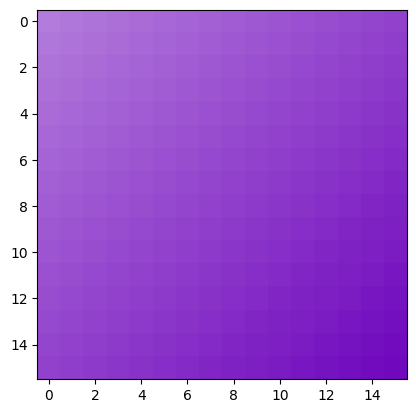

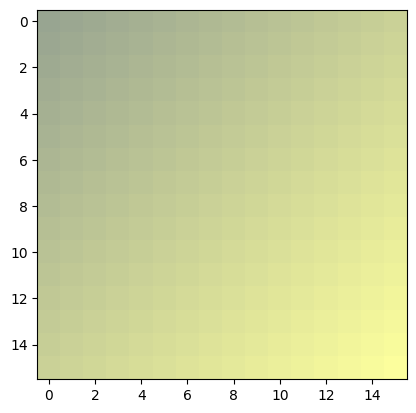

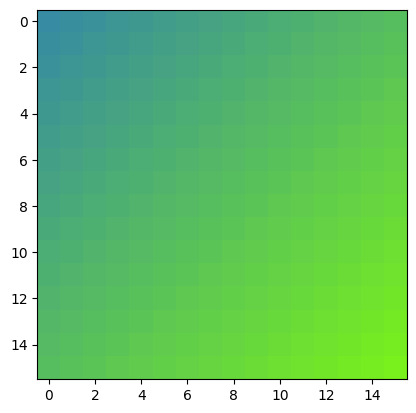

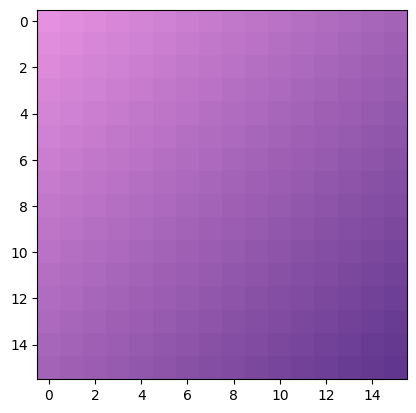

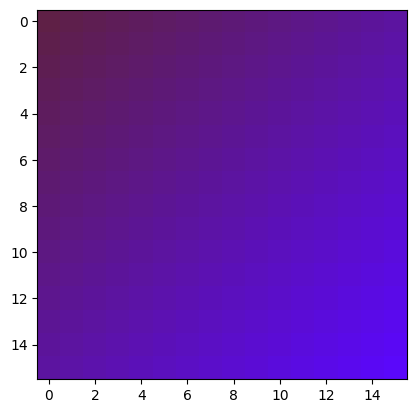

In [4]:
def gradient_images(n_images: int, img_size: tuple[int, int, int]) -> t.Tensor:
    '''
    Generate n_images of img_size, each a color gradient
    '''
    (C, H, W) = img_size
    corners = t.randint(0, 255, (2, n_images, C))
    xs = t.linspace(0, W / (W + H), W)
    ys = t.linspace(0, H / (W + H), H)
    (x, y) = t.meshgrid(xs, ys, indexing="xy")
    grid = x + y
    grid = grid / grid[-1, -1]
    grid = repeat(grid, "h w -> b c h w", b=n_images, c=C)
    base = repeat(corners[0], "n c -> n c h w", h=H, w=W)
    ranges = repeat(corners[1] - corners[0], "n c -> n c h w", h=H, w=W)
    gradients = base + grid * ranges
    assert gradients.shape == (n_images, C, H, W)
    return gradients / 255


def plot_img(img: t.Tensor, title: Optional[str] = None) -> None:
    img = rearrange(img, "c h w -> h w c")
    plt.imshow(img.numpy())
    if title:
        plt.title(title)
    plt.show()


if MAIN:
    print("A few samples from the input distribution: ")
    img_shape = (3, 16, 16)
    n_images = 5
    imgs = gradient_images(n_images, img_shape)
    for i in range(n_images):
        plot_img(imgs[i])

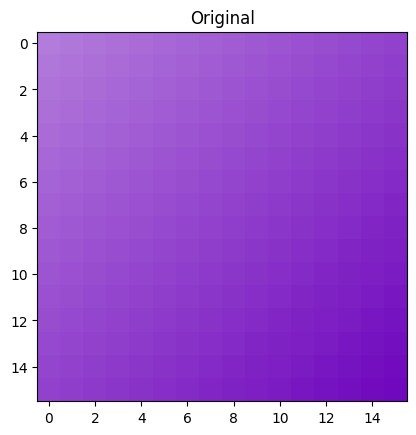

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


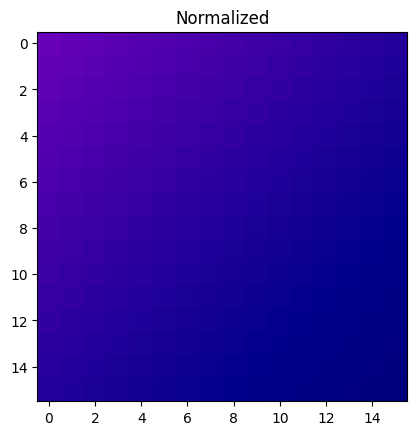

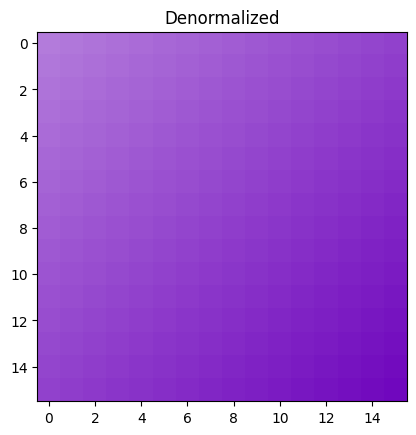

In [5]:
def normalize_img(img: t.Tensor) -> t.Tensor:
    return img * 2 - 1


def denormalize_img(img: t.Tensor) -> t.Tensor:
    return ((img + 1) / 2).clamp(0, 1)


if MAIN:
    plot_img(imgs[0], "Original")
    plot_img(normalize_img(imgs[0]), "Normalized")
    plot_img(denormalize_img(normalize_img(imgs[0])), "Denormalized")

In [6]:
def linear_schedule(max_steps: int, min_noise: float = 0.0001, max_noise: float = 0.02) -> t.Tensor:
    '''
    Return the forward process variances as in the paper.

    max_steps: total number of steps of noise addition
    out: shape (step=max_steps, ) the amount of noise at each step
    '''
    return t.linspace(min_noise, max_noise, max_steps)

if MAIN:
    betas = linear_schedule(max_steps=200)

In [5]:
def q_forward_slow(x: t.Tensor, num_steps: int, betas: t.Tensor) -> t.Tensor:
    '''Return the input image with num_steps iterations of noise added according to schedule.
    x: shape (channels, height, width)
    betas: shape (T, ) with T >= num_steps

    out: shape (channels, height, width)
    '''
    for i in range(num_steps):
        pass

if MAIN:
    x = normalize_img(gradient_images(1, (3, 16, 16))[0])
    for n in [1, 10, 50, 200]:
        xt = q_forward_slow(x, n, betas)
        plot_img(denormalize_img(xt), f"Equation 2 after {n} step(s)")
    plot_img(denormalize_img(t.randn_like(xt)), "Random Gaussian noise")

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [ ]:
def q_forward_fast(x: t.Tensor, num_steps: int, betas: t.Tensor) -> t.Tensor:
    '''Equivalent to Equation 2 but without a for loop.'''
    pass

if MAIN:
    for n in [1, 10, 50, 200]:
        xt = q_forward_fast(x, n, betas)
        plot_img(denormalize_img(xt), f"Equation 4 after {n} steps")

Compare That the slow and the fast function look similar

## Noise Scheduler

In [6]:
class NoiseSchedule(nn.Module):
    betas: t.Tensor
    alphas: t.Tensor
    alpha_bars: t.Tensor

    def __init__(self, max_steps: int, device: Union[t.device, str]) -> None:
        super().__init__()
        self.max_steps = max_steps
        self.device = device
        pass

    @t.inference_mode()
    def beta(self, num_steps: Union[int, t.Tensor]) -> t.Tensor:
        '''
        Returns the beta(s) corresponding to a given number of noise steps
        num_steps: int or int tensor of shape (batch_size,)
        Returns a tensor of shape (batch_size,), where batch_size is one if num_steps is an int
        '''
        pass

    @t.inference_mode()
    def alpha(self, num_steps: Union[int, t.Tensor]) -> t.Tensor:
        '''
        Returns the alphas(s) corresponding to a given number of noise steps
        num_steps: int or int tensor of shape (batch_size,)
        Returns a tensor of shape (batch_size,), where batch_size is one if num_steps is an int
        '''
        pass

    @t.inference_mode()
    def alpha_bar(self, num_steps: Union[int, t.Tensor]) -> t.Tensor:
        '''
        Returns the alpha_bar(s) corresponding to a given number of noise steps
        num_steps: int or int tensor of shape (batch_size,)
        Returns a tensor of shape (batch_size,), where batch_size is one if num_steps is an int
        '''
        pass

    def __len__(self) -> int:
        return self.max_steps

In [7]:
def noise_img(
    img: t.Tensor, noise_schedule: NoiseSchedule, max_steps: Optional[int] = None
) -> tuple[t.Tensor, t.Tensor, t.Tensor]:
    '''
    Adds a uniform random number of steps of noise to each image in img.

    img: An image tensor of shape (B, C, H, W)
    noise_schedule: The NoiseSchedule to follow
    max_steps: if provided, only perform the first max_steps of the schedule

    Returns a tuple composed of:
    num_steps: an int tensor of shape (B,) of the number of steps of noise added to each image
    noise: the unscaled, standard Gaussian noise added to each image, a tensor of shape (B, C, H, W)
    noised: the final noised image, a tensor of shape (B, C, H, W)
    '''
    pass

if MAIN:
    noise_schedule = NoiseSchedule(max_steps=200, device="cpu")
    img = gradient_images(1, (3, 16, 16))
    (num_steps, noise, noised) = noise_img(normalize_img(img), noise_schedule, max_steps=10)
    plot_img(img[0], "Gradient")
    plot_img(noise[0], "Applied Unscaled Noise")
    plot_img(denormalize_img(noised[0]), "Gradient with Noise Applied")

TypeError: cannot unpack non-iterable NoneType object

In [8]:
def reconstruct(noisy_img: t.Tensor, noise: t.Tensor, num_steps: t.Tensor, noise_schedule: NoiseSchedule) -> t.Tensor:
    '''
    Subtract the scaled noise from noisy_img to recover the original image. We'll later use this with the model's output to log reconstructions during training. We'll use a different method to sample images once the model is trained.

    Returns img, a tensor with shape (B, C, H, W)
    '''
    pass

if MAIN:
    reconstructed = reconstruct(noised, noise, num_steps, noise_schedule)
    denorm = denormalize_img(reconstructed)
    plot_img(img[0], "Original Gradient")
    plot_img(denorm[0], "Reconstruction")
    t.testing.assert_close(denorm, img)

NameError: name 'noised' is not defined

In [9]:
class DiffusionModel(nn.Module, ABC):
    img_shape: tuple[int, ...]
    noise_schedule: Optional[NoiseSchedule]

    @abstractmethod
    def forward(self, images: t.Tensor, num_steps: t.Tensor) -> t.Tensor:
        ...

@dataclass(frozen=True)
class TinyDiffuserConfig:
    img_shape: tuple[int, ...]
    hidden_size: int
    max_steps: int

class TinyDiffuser(DiffusionModel):
    def __init__(self, config: TinyDiffuserConfig):
        '''
        A toy diffusion model composed of an MLP (Linear, ReLU, Linear)
        '''
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.img_shape = config.img_shape
        self.noise_schedule = None
        self.max_steps = config.max_steps
        pass

    def forward(self, images: t.Tensor, num_steps: t.Tensor) -> t.Tensor:
        '''
        Given a batch of images and noise steps applied, attempt to predict the noise that was applied.
        images: tensor of shape (B, C, H, W)
        num_steps: tensor of shape (B,)

        Returns
        noise_pred: tensor of shape (B, C, H, W)
        '''
        pass

if MAIN:
    img_shape = (3, 4, 5)
    n_images = 5
    imgs = gradient_images(n_images, img_shape)
    n_steps = t.zeros(imgs.size(0))
    model_config = TinyDiffuserConfig(img_shape, 16, 100)
    model = TinyDiffuser(model_config)
    out = model(imgs, n_steps)
    plot_img(out[0].detach(), "Noise prediction of untrained model")

TypeError: 'NoneType' object is not subscriptable

## Training Loop

In [10]:
def log_images(
    img: t.Tensor, noised: t.Tensor, noise: t.Tensor, noise_pred: t.Tensor, reconstructed: t.Tensor, num_images: int = 3
) -> list[wandb.Image]:
    '''
    Convert tensors to a format suitable for logging to Weights and Biases. Returns an image with the ground truth in the upper row, and model reconstruction on the bottom row. Left is the noised image, middle is noise, and reconstructed image is in the rightmost column.
    '''
    actual = t.cat((noised, noise, img), dim=-1)
    pred = t.cat((noised, noise_pred, reconstructed), dim=-1)
    log_img = t.cat((actual, pred), dim=-2)
    images = [wandb.Image(i) for i in log_img[:num_images]]
    return images


def train(
    model: DiffusionModel, config_dict: dict[str, Any], trainset: TensorDataset, testset: Optional[TensorDataset] = None
) -> DiffusionModel:
    wandb.init(project="diffusion_models", config=config_dict, mode="enabled")
    config = wandb.config
    print(f"Training with config: {config}")
    pass


if MAIN:
    config: dict[str, Any] = dict(
        lr=0.001,
        image_shape=(3, 4, 5),
        hidden_size=128,
        epochs=20,
        max_steps=100,
        batch_size=128,
        img_log_interval=200,
        n_images_to_log=3,
        n_images=50000,
        n_eval_images=1000,
        device=t.device("cuda") if t.cuda.is_available() else t.device("cpu"),
    )
    images = normalize_img(gradient_images(config["n_images"], config["image_shape"]))
    train_set = TensorDataset(images)
    images = normalize_img(gradient_images(config["n_eval_images"], config["image_shape"]))
    test_set = TensorDataset(images)
    model_config = TinyDiffuserConfig(config["image_shape"], config["hidden_size"], config["max_steps"])
    model = TinyDiffuser(model_config).to(config["device"])
    model = train(model, config, train_set, test_set)

: 

: 

## Sampling from the diffusion model

In [1]:
def sample(model: DiffusionModel, n_samples: int, return_all_steps: bool = False) -> Union[t.Tensor, list[t.Tensor]]:
    '''
    Sample, following Algorithm 2 in the DDPM paper

    model: The trained noise-predictor
    n_samples: The number of samples to generate
    return_all_steps: if true, return a list of the reconstructed tensors generated at each step, rather than just the final reconstructed image tensor.

    out: shape (B, C, H, W), the denoised images
            or (T, B, C, H, W), if return_all_steps=True (where ith element is batched result of (i+1) steps of sampling)
    '''
    schedule = model.noise_schedule
    assert schedule is not None
    pass


if MAIN:
    print("Generating multiple images")
    assert isinstance(model, DiffusionModel)
    with t.inference_mode():
        samples = sample(model, 5)
    for s in samples:
        plot_img(denormalize_img(s).cpu())
if MAIN:
    print("Printing sequential denoising")
    assert isinstance(model, DiffusionModel)
    with t.inference_mode():
        samples = sample(model, 1, return_all_steps=True)
    for (i, s) in enumerate(samples):
        if i % (len(samples) // 20) == 0:
            plot_img(denormalize_img(s[0]), f"Step {i}")

NameError: name 'DiffusionModel' is not defined